In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scist
import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)

In [2]:
df=pd.io.gbq.read_gbq('SELECT * FROM projekt-zaliczeniowy-401114.movies.movies',project_id='projekt-zaliczeniowy-401114')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Poster_Link      1000 non-null   object 
 1   Series_Title     1000 non-null   object 
 2   Released_Year    1000 non-null   Int64  
 3   Certificate      899 non-null    object 
 4   IMDB_Rating      1000 non-null   float64
 5   Overview         1000 non-null   object 
 6   Meta_score       843 non-null    float64
 7   Director         1000 non-null   object 
 8   Star1            1000 non-null   object 
 9   Star2            1000 non-null   object 
 10  Star3            1000 non-null   object 
 11  Star4            1000 non-null   object 
 12  No_of_Votes      1000 non-null   Int64  
 13  Gross            831 non-null    float64
 14  Runtime_minutes  1000 non-null   Int64  
 15  Genre1           1000 non-null   object 
 16  Genre2           895 non-null    object 
 17  Genre3         

## Rating vs. Popularity

In [ ]:
df_imdb=pd.io.gbq.read_gbq('''SELECT IMDB_Rating, AVG(No_of_Votes)/1000000 AS No_of_Votes, AVG(Gross)/1000000 AS Gross 
                              FROM projekt-zaliczeniowy-401114.movies.movies
                              GROUP BY IMDB_Rating
                              ORDER BY IMDB_Rating''',project_id='projekt-zaliczeniowy-401114').set_index('IMDB_Rating')
df_imdb.loc[9.1]=(np.nan,np.nan) # Adding the missing value
df_imdb=df_imdb.sort_index() # Sorting by index, as the added value is at the bottom of the dataframe
df_meta=pd.io.gbq.read_gbq('''SELECT 
                                CASE
                                    WHEN Meta_score > 20 AND Meta_score <=30 THEN '(20,30]'
                                    WHEN Meta_score > 30 AND Meta_score <=40 THEN '(30,40]'
                                    WHEN Meta_score > 40 AND Meta_score <=50 THEN '(40,50]'
                                    WHEN Meta_score > 50 AND Meta_score <=60 THEN '(50,60]'
                                    WHEN Meta_score > 60 AND Meta_score <=70 THEN '(60,70]'
                                    WHEN Meta_score > 70 AND Meta_score <=80 THEN '(70,80]'
                                    WHEN Meta_score > 80 AND Meta_score <=90 THEN '(80,100]'
                                    WHEN Meta_score > 90 AND Meta_score <=100 THEN '(90,100]'
                                END AS Meta_score,
                                AVG(No_of_Votes)/1000000 AS No_of_Votes, 
                                AVG(Gross)/1000000 AS Gross 
                              FROM projekt-zaliczeniowy-401114.movies.movies
                              WHERE Meta_score IS NOT NULL
                              GROUP BY Meta_score
                              ORDER BY Meta_score''',project_id='projekt-zaliczeniowy-401114').set_index('Meta_score')

In [ ]:
df_imdb

In [ ]:
df_meta

In [ ]:
sns.set(style='white')
fig,ax=plt.subplots(figsize=(16,9))
df_meta['Gross'].plot.bar(width=1,color=sns.color_palette("RdYlGn",8),ax=ax)
ax.set_title('Average gross income [mln $]',fontsize=20)
ax.set_xlabel('Meta Critic score',fontsize=17)
ax.set_xticklabels(df_meta.index,rotation=0,fontsize=14)
ax.set_ylabel(None)
ax.set_yticks([])
ax.bar_label(ax.containers[0],fmt='%.1f',fontsize=14)
plt.show()

In [ ]:
fig,ax=plt.subplots(figsize=(16,9))
df_imdb['Gross'].plot.bar(width=1,color=sns.light_palette(('#66fc03'),len(df_imdb)),ax=ax)
ax.set_title('Average gross income [mln $]',fontsize=20)
ax.containers[0].datavalues[-3]=np.nan # Removing the bar label of the missing value
ax.set_xlabel('IMDB score',fontsize=17)
ax.set_xticklabels(df_imdb.index,rotation=0,fontsize=14)
ax.set_ylabel(None)
ax.set_yticks([])
ax.bar_label(ax.containers[0],fmt='%.1f',fontsize=14)
plt.show()

In [ ]:
fig,ax=plt.subplots(figsize=(16,9))
df_imdb['No_of_Votes'].plot.bar(width=1,color=sns.light_palette(('#66fc03'),len(df_imdb)),ax=ax)
ax.set_title('Average number of votes [mln]',fontsize=20)
ax.containers[0].datavalues[-3]=np.nan # Removing the bar label of the missing value
ax.set_xlabel('IMDB score',fontsize=17)
ax.set_xticklabels(df_imdb.index,rotation=0,fontsize=14)
ax.set_ylabel(None)
ax.set_yticks([])
ax.bar_label(ax.containers[0],fmt='%.1f',fontsize=14)
plt.show()

## IMDB score vs. Meta score

In [ ]:
df_scores=pd.io.gbq.read_gbq('''SELECT IMDB_Rating,Meta_score 
                                FROM projekt-zaliczeniowy-401114.movies.movies
                                WHERE Meta_score IS NOT NULL''',project_id='projekt-zaliczeniowy-401114')
df_scores.corr(method='spearman')['IMDB_Rating']['Meta_score']

# Genres #

In [23]:
df_genre=pd.io.gbq.read_gbq('''  SELECT 
                            IF(count>=50, genre, 'Other') AS Genre,
                            SUM(count) AS Count,
                            ROUND(SUM(imdb_sum)/SUM(count),2) AS Mean_IMDB_Rating,
                            ROUND(SUM(gross_mln_sum)/SUM(count),2) AS Mean_Gross_mln,
                            ROUND(SUM(votes_mln_sum)/SUM(count),2) AS Mean_Votes_mln
                        FROM
                            (
                            SELECT 
                                DISTINCT Genre1 AS genre, 
                                COUNT(*) AS count,
                                SUM(IMDB_Rating) AS imdb_sum,
                                SUM(Gross)/1000000 as gross_mln_sum,
                                SUM(No_Of_Votes)/1000000 as votes_mln_sum
                            FROM projekt-zaliczeniowy-401114.movies.movies
                            GROUP BY genre
                            )
                        GROUP BY genre
                        Order BY Count''',project_id='projekt-zaliczeniowy-401114').set_index('Genre')
df_genre

,Count,Mean_IMDB_Rating,Mean_Gross_mln,Mean_Votes_mln
Genre,,,,
Other,35,7.98,43.64,0.30
Adventure,72,7.94,73.25,0.31
Animation,82,7.93,104.56,0.27
Biography,88,7.94,53.98,0.27
Crime,107,8.02,29.72,0.31
Comedy,155,7.90,26.87,0.18
Action,172,7.95,116.38,0.42
Drama,289,7.96,31.32,0.21


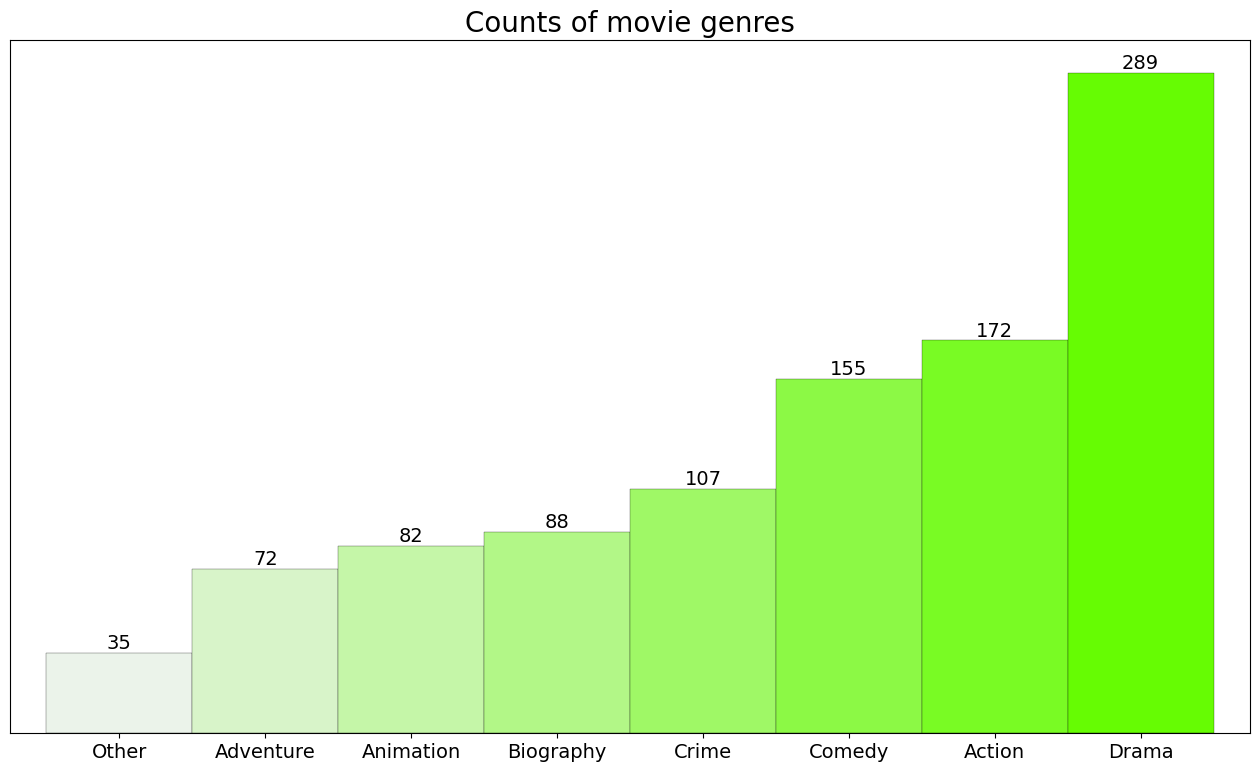

In [52]:
fig,ax=plt.subplots(figsize=(16,9))
df_genre['Count'].plot.bar( width=1,
                            color=sns.light_palette(('#66fc03'),len(df_genre)),
                            edgecolor='black',
                            linewidth=0.2,ax=ax)
ax.set_title('Counts of movie genres',fontsize=20)
ax.set_xlabel(None)
ax.set_xticklabels(df_genre.index,rotation=0,fontsize=14)
ax.set_ylabel(None)
ax.set_yticks([])
ax.bar_label(ax.containers[0],fmt='%.0f',fontsize=14)
plt.show()

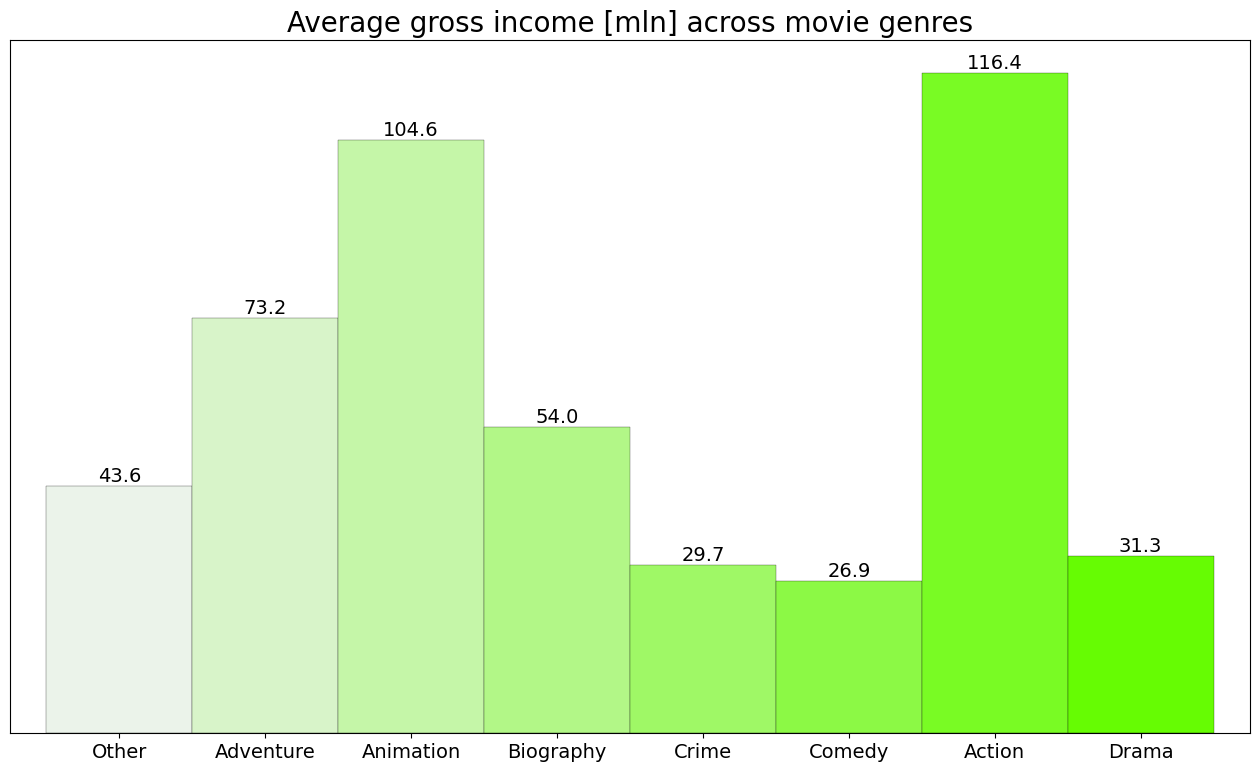

In [50]:
fig,ax=plt.subplots(figsize=(16,9))
df_genre['Mean_Gross_mln'].plot.bar( width=1,
                            color=sns.light_palette(('#66fc03'),len(df_genre)),
                            edgecolor='black',
                            linewidth=0.2,ax=ax)
ax.set_title('Average gross income [mln] across movie genres',fontsize=20)
ax.set_xlabel(None)
ax.set_xticklabels(df_genre.index,rotation=0,fontsize=14)
ax.set_ylabel(None)
ax.set_yticks([])
ax.bar_label(ax.containers[0],fmt='%.1f',fontsize=14)
plt.show()

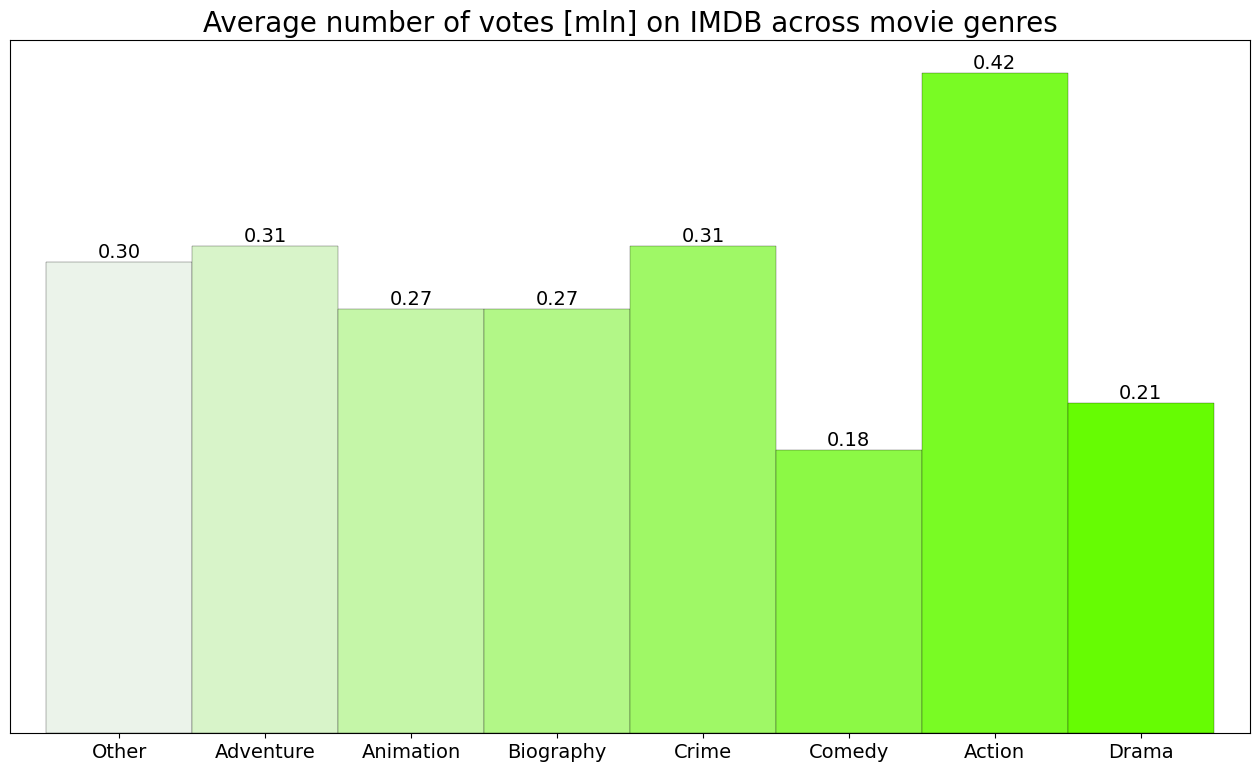

In [51]:
fig,ax=plt.subplots(figsize=(16,9))
df_genre['Mean_Votes_mln'].plot.bar( width=1,
                            color=sns.light_palette(('#66fc03'),len(df_genre)),
                            edgecolor='black',
                            linewidth=0.2,ax=ax)
ax.set_title('Average number of votes [mln] on IMDB across movie genres',fontsize=20)
ax.set_xlabel(None)
ax.set_xticklabels(df_genre.index,rotation=0,fontsize=14)
ax.set_ylabel(None)
ax.set_yticks([])
ax.bar_label(ax.containers[0],fmt='%.2f',fontsize=14)
plt.show()

# Directors #

In [91]:
pd.io.gbq.read_gbq('''  SELECT 
                            DISTINCT Director,
                            COUNT(*) as Count
                        FROM projekt-zaliczeniowy-401114.movies.movies
                        GROUP BY Director
                        HAVING Count>5
                        ORDER BY Count DESC''',project_id='projekt-zaliczeniowy-401114').head(10)

,Director,Count
0,Alfred Hitchcock,14
1,Steven Spielberg,13
2,Hayao Miyazaki,11
3,Akira Kurosawa,10
4,Martin Scorsese,10
5,Stanley Kubrick,9
6,Woody Allen,9
7,Billy Wilder,9
8,David Fincher,8
9,Clint Eastwood,8


choosing spielberg as he is the most popular modern director

In [108]:
df_spielberg=pd.io.gbq.read_gbq(''' SELECT 
                                        Series_Title,
                                        Released_Year,
                                        IMDB_Rating,
                                        Gross/1000000 as Gross_mln
                                    FROM projekt-zaliczeniowy-401114.movies.movies
                                    WHERE Director="Steven Spielberg"
                                    ORDER BY Released_Year''',project_id='projekt-zaliczeniowy-401114')
df_spielberg

,Series_Title,Released_Year,IMDB_Rating,Gross_mln
0,Jaws,1975,8.0,260.000000
1,Close Encounters of the Third Kind,1977,7.6,132.088635
2,Raiders of the Lost Ark,1981,8.4,248.159971
3,E.T. the Extra-Terrestrial,1982,7.8,435.110554
4,The Color Purple,1985,7.8,98.467863
5,Empire of the Sun,1987,7.7,22.238696
6,Indiana Jones and the Last Crusade,1989,8.2,197.171806
7,Schindler's List,1993,8.9,96.898818
8,Jurassic Park,1993,8.1,402.453882
9,Saving Private Ryan,1998,8.6,216.540909


gross is not adjusted for inflation

In [131]:
df_inflation=pd.read_csv('USA_Inflation.csv')
df_inflation.columns=['Year','CPI']
df_inflation['Year']=df_inflation['Year'].str[:4].astype(int)
df_inflation['CPI']=(df_inflation['CPI']/100)+1
df_inflation.tail(5)

,Year,CPI
43,2018,1.024426
44,2019,1.018122
45,2020,1.012336
46,2021,1.046979
47,2022,1.080028


In [133]:
def get_inflation(year):
    return df_inflation[(df_inflation['Year']>year)]['CPI'].prod()
df_spielberg['Gross_mln_adjusted']=0
for i in df_spielberg.index:
    df_spielberg.at[i,'Gross_mln_adjusted']=df_spielberg['Gross_mln'].iloc[i]*get_inflation(df_spielberg['Released_Year'].iloc[i])
df_spielberg

,Series_Title,Released_Year,IMDB_Rating,Gross_mln,Gross_mln_adjusted
0,Jaws,1975,8.0,260.000000,1413.879436
1,Close Encounters of the Third Kind,1977,7.6,132.088635,637.806492
2,Raiders of the Lost Ark,1981,8.4,248.159971,798.737813
3,E.T. the Extra-Terrestrial,1982,7.8,435.110554,1319.556921
4,The Color Purple,1985,7.8,98.467863,267.899946
5,Empire of the Sun,1987,7.7,22.238696,57.278449
6,Indiana Jones and the Last Crusade,1989,8.2,197.171806,465.474309
7,Schindler's List,1993,8.9,96.898818,196.305155
8,Jurassic Park,1993,8.1,402.453882,815.322346
9,Saving Private Ryan,1998,8.6,216.540909,388.763939


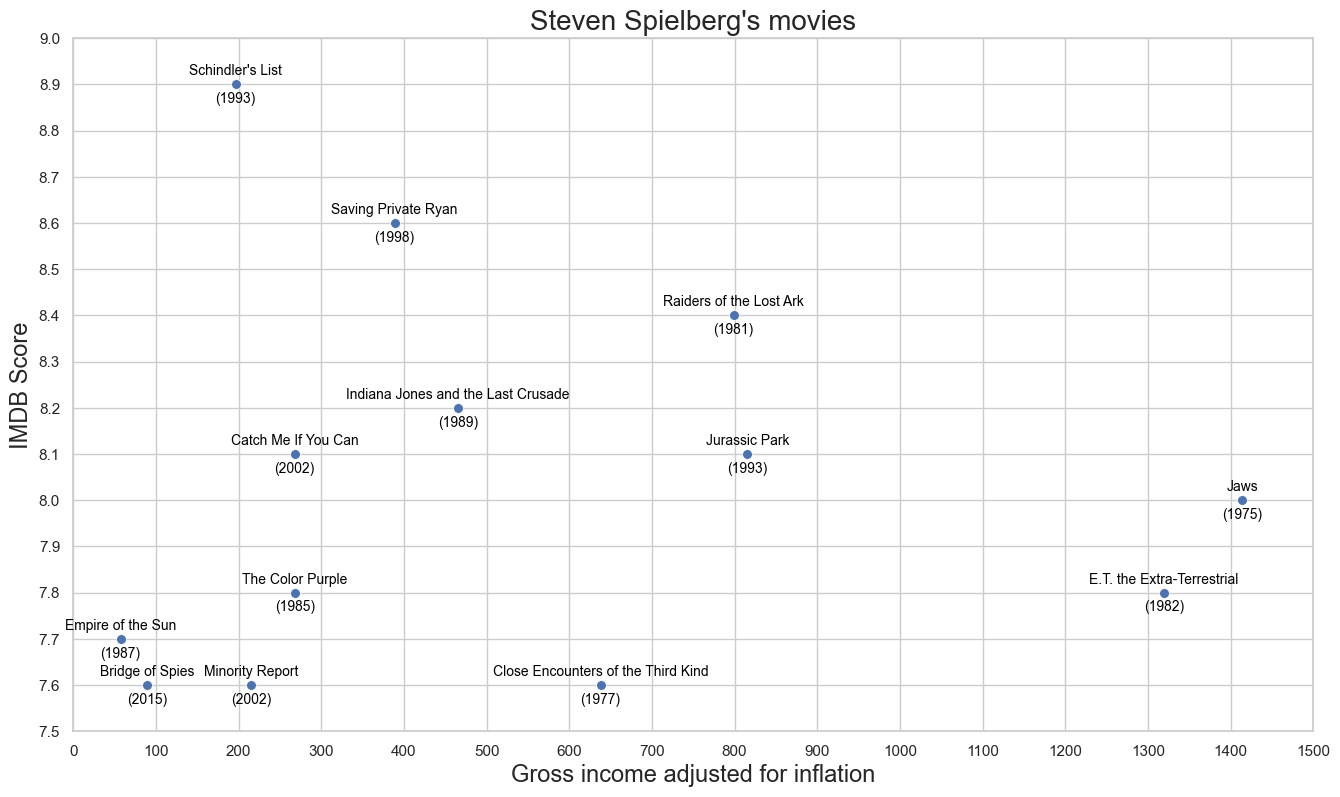

In [166]:
sns.set(style='whitegrid')
fig,ax=plt.subplots(figsize=(16,9))
sns.scatterplot(df_spielberg,
                x='Gross_mln_adjusted',
                y='IMDB_Rating',
                s=50,
                ax=ax)
for i in df_spielberg.index:
    plt.text(   df_spielberg['Gross_mln_adjusted'].iloc[i],
                df_spielberg['IMDB_Rating'].iloc[i]+0.02,
                df_spielberg['Series_Title'].iloc[i],
                horizontalalignment='center',
                size='small', 
                color='black')
for i in df_spielberg.index:
    plt.text(   df_spielberg['Gross_mln_adjusted'].iloc[i],
                df_spielberg['IMDB_Rating'].iloc[i]-0.04,
                f"({df_spielberg['Released_Year'].iloc[i]})",
                horizontalalignment='center',
                size='small', 
                color='black')
ax.set_title("Steven Spielberg's movies",fontsize=20)
ax.set_xlabel('Gross income adjusted for inflation',fontsize=17)
ax.set_xticks(np.arange(0,1501,100))
ax.set_xlim(left=0)
ax.set_ylabel('IMDB Score',fontsize=17)
ax.set_yticks(np.arange(7.5,9.1,0.1))
plt.show()